# Part 1: GAN

# Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST


In [2]:
# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])


transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Check dataset information
print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

Train dataset length: 60000
Test dataset length: 10000


In [3]:
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


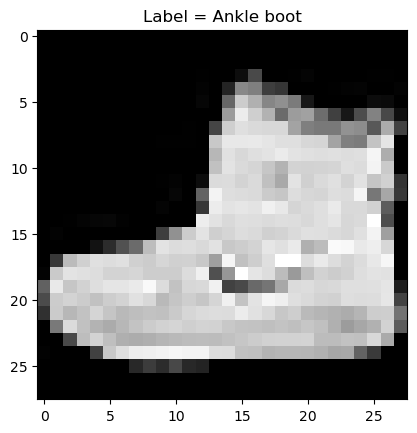

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def print_image(img, label):
    img_norm = denorm(img)
    plt.imshow(img_norm[0], cmap='gray')
    plt.title(f'Label = {class_names[label]}')
    

img, label = train_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)
print_image(img, label)

In [5]:
# Break Data in mini batches
from torch.utils.data import DataLoader

batch_size = 100

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

first batch
torch.Size([100, 1, 28, 28])


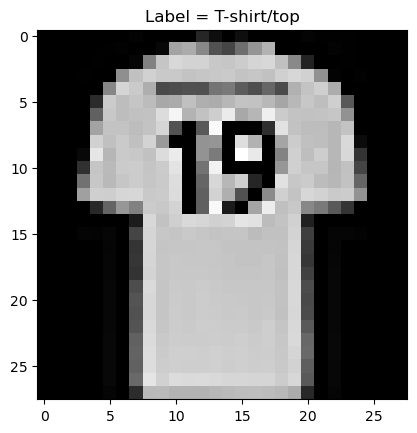

In [6]:
for img_batch, label_batch in train_loader:
    print('first batch')
    print(img_batch.shape)
    print_image(img=img_batch[0], label=label_batch[0].item())
    break

In [7]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage


def show_images(images_path):
    
    n = len(images_path)
    plt.figure(figsize=(5*n, 5))
    
    for i, path in enumerate(images_path):
        # Plot first image
        plt.subplot(1, n, i+1)
        image = PILImage.open(path)
        plt.imshow(image)
        plt.title(path)
        plt.axis('off')
        
    plt.show()
    

# Step2. Train the GAN model to produce images in this new domain.

In [8]:
# Setting Device configuration to get performance boost

device = torch.device('cuda' if torch.cuda.is_available() else ( 
    'mps' if torch.backends.mps.is_available() else 'cpu'))

# device = "cpu"
device

device(type='mps')

In [9]:
image_size = 784
hidden_size = 256

## Discriminator Network


In [10]:
import torch.nn as nn

def discriminator_network():
    return nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

D = discriminator_network()
D.to(device);

## Generator Network

In [11]:
latent_size = 64

def generator_network():
    return nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

G = generator_network()

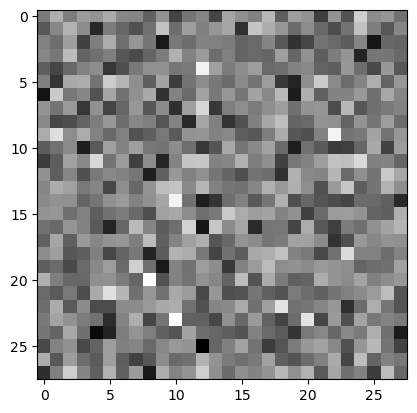

In [12]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())
plt.imshow(gen_imgs[0], cmap='gray');

In [13]:
G.to(device);

In [14]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

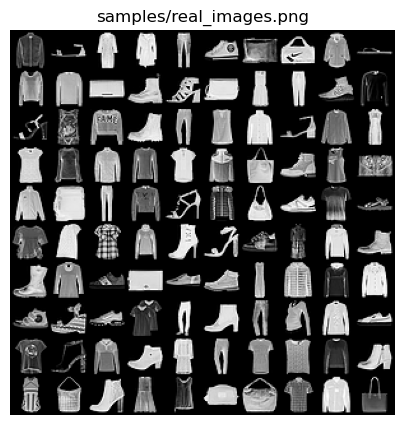

In [15]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in train_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

show_images([os.path.join(sample_dir, 'real_images.png')])

In [16]:
def save_fake_images(G, index, sample_dir):
    sample_vectors = torch.randn(batch_size, latent_size).to(device)

    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname  = 'fake_images-{0:0=4d}.png'.format(index)
    print('\tSaving ',  os.path.join(sample_dir, fake_fname))
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# # Before training
# save_fake_images(G, 0, sample_dir=sample_dir)
# show_images([os.path.join(sample_dir, 'fake_images-0000.png')])

In [17]:
def reset_grad(g_optimizer, d_optimizer):
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(G, D, images, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad(g_optimizer, d_optimizer)
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

def train_generator(G, D, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad(g_optimizer, d_optimizer)
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images


def train_discriminator2(G, D, real_images, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    # Create the labels which are later used as input for the BCE loss
    d_optimizer.zero_grad()
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    z = torch.randn(batch_size, latent_size).to(device)
    
    # Loss for real images
    real_score = D(real_images)
    d_loss_real = criterion(real_score, real_labels)

    # Loss for fake images
    fake_images = G(z)
    fake_score = D(fake_images)
    d_loss_fake = criterion(fake_score, fake_labels)

    d_loss = d_loss_real + d_loss_fake  # Combine losses
    d_loss.backward()  # Compute gradients
    d_optimizer.step() # Adjust the parameters using backprop
    
    return d_loss, real_score, fake_score

def train_generator2(G, D, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    g_optimizer.zero_grad()
    
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_output = D(fake_images)
    g_loss = criterion(fake_output, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images



def train_gan(G, D, data_loader, num_epochs, sample_dir, 
              batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    save_fake_images(G, 0, sample_dir=sample_dir)
#     show_images([os.path.join(sample_dir, 'fake_images-0000.png')])
    
    total_step = len(data_loader)
    d_losses, g_losses, real_scores, fake_scores = [], [], [], []

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            
            # Load a batch & transform to vectors
            images = images.reshape(batch_size, -1).to(device)

            # Train the discriminator and generator
            d_loss, real_score, fake_score = train_discriminator2(G, D, images, batch_size, latent_size, 
                                                                 criterion, g_optimizer, d_optimizer)
            g_loss, fake_images = train_generator2(G, D, batch_size, latent_size, 
                                                  criterion, g_optimizer, d_optimizer)

            # Inspect the losses
            if (i+1) % (total_step//3) == 0:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], ' +
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, ' + 
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

                
        # Sample and save images
        save_fake_images(G, epoch+1, sample_dir)

    return d_losses, g_losses, real_scores, fake_scores
        
        

	Saving  samples/fake_images-0000.png


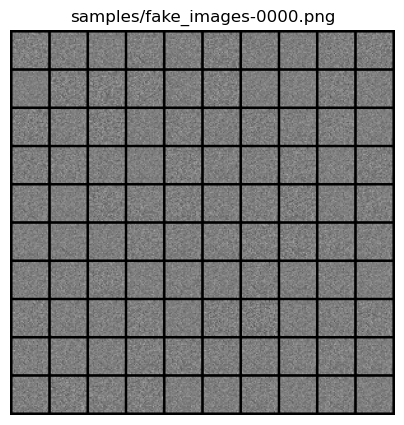

Epoch [0/60], Step [200/600], d_loss: 0.0665, g_loss: 4.2362, D(x): 0.99, D(G(z)): 0.05
Epoch [0/60], Step [400/600], d_loss: 0.2017, g_loss: 5.6076, D(x): 0.94, D(G(z)): 0.09
Epoch [0/60], Step [600/600], d_loss: 0.0290, g_loss: 4.7798, D(x): 0.99, D(G(z)): 0.02
	Saving  samples/fake_images-0001.png
Epoch [1/60], Step [200/600], d_loss: 0.0570, g_loss: 4.1736, D(x): 0.99, D(G(z)): 0.04
Epoch [1/60], Step [400/600], d_loss: 0.0890, g_loss: 3.9492, D(x): 0.97, D(G(z)): 0.05
Epoch [1/60], Step [600/600], d_loss: 0.0226, g_loss: 4.8708, D(x): 1.00, D(G(z)): 0.02
	Saving  samples/fake_images-0002.png
Epoch [2/60], Step [200/600], d_loss: 0.0279, g_loss: 5.6419, D(x): 0.99, D(G(z)): 0.01
Epoch [2/60], Step [400/600], d_loss: 0.0259, g_loss: 6.9680, D(x): 0.99, D(G(z)): 0.01
Epoch [2/60], Step [600/600], d_loss: 0.0395, g_loss: 6.8920, D(x): 0.99, D(G(z)): 0.03
	Saving  samples/fake_images-0003.png
Epoch [3/60], Step [200/600], d_loss: 0.0736, g_loss: 5.4581, D(x): 0.97, D(G(z)): 0.01
Epoch 

Epoch [27/60], Step [200/600], d_loss: 0.3864, g_loss: 3.0425, D(x): 0.87, D(G(z)): 0.10
Epoch [27/60], Step [400/600], d_loss: 0.2767, g_loss: 3.8521, D(x): 0.88, D(G(z)): 0.06
Epoch [27/60], Step [600/600], d_loss: 0.5731, g_loss: 3.1585, D(x): 0.92, D(G(z)): 0.29
	Saving  samples/fake_images-0028.png
Epoch [28/60], Step [200/600], d_loss: 0.2882, g_loss: 3.7485, D(x): 0.91, D(G(z)): 0.10
Epoch [28/60], Step [400/600], d_loss: 0.5872, g_loss: 3.8600, D(x): 0.81, D(G(z)): 0.07
Epoch [28/60], Step [600/600], d_loss: 0.3270, g_loss: 4.0705, D(x): 0.87, D(G(z)): 0.07
	Saving  samples/fake_images-0029.png
Epoch [29/60], Step [200/600], d_loss: 0.3779, g_loss: 3.4601, D(x): 0.90, D(G(z)): 0.11
Epoch [29/60], Step [400/600], d_loss: 0.5013, g_loss: 3.3647, D(x): 0.81, D(G(z)): 0.06
Epoch [29/60], Step [600/600], d_loss: 0.3603, g_loss: 3.3248, D(x): 0.85, D(G(z)): 0.06
	Saving  samples/fake_images-0030.png
Epoch [30/60], Step [200/600], d_loss: 0.4011, g_loss: 2.7484, D(x): 0.89, D(G(z)): 0

Epoch [54/60], Step [200/600], d_loss: 0.3345, g_loss: 3.0773, D(x): 0.87, D(G(z)): 0.11
Epoch [54/60], Step [400/600], d_loss: 0.6171, g_loss: 1.9304, D(x): 0.84, D(G(z)): 0.23
Epoch [54/60], Step [600/600], d_loss: 0.9482, g_loss: 1.8013, D(x): 0.69, D(G(z)): 0.24
	Saving  samples/fake_images-0055.png
Epoch [55/60], Step [200/600], d_loss: 0.5909, g_loss: 2.1968, D(x): 0.80, D(G(z)): 0.20
Epoch [55/60], Step [400/600], d_loss: 0.7105, g_loss: 1.7786, D(x): 0.80, D(G(z)): 0.23
Epoch [55/60], Step [600/600], d_loss: 0.8774, g_loss: 1.5564, D(x): 0.77, D(G(z)): 0.30
	Saving  samples/fake_images-0056.png
Epoch [56/60], Step [200/600], d_loss: 0.9899, g_loss: 2.3652, D(x): 0.70, D(G(z)): 0.28
Epoch [56/60], Step [400/600], d_loss: 0.7129, g_loss: 2.0191, D(x): 0.76, D(G(z)): 0.22
Epoch [56/60], Step [600/600], d_loss: 0.7352, g_loss: 2.4615, D(x): 0.79, D(G(z)): 0.25
	Saving  samples/fake_images-0057.png
Epoch [57/60], Step [200/600], d_loss: 0.8205, g_loss: 2.4136, D(x): 0.73, D(G(z)): 0

In [18]:
num_epochs  = 60
criterion   = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

d_losses, g_losses, real_scores, fake_scores = train_gan(G, D, train_loader, num_epochs, sample_dir, 
                                                         batch_size, latent_size, 
                                                         criterion, g_optimizer, d_optimizer)

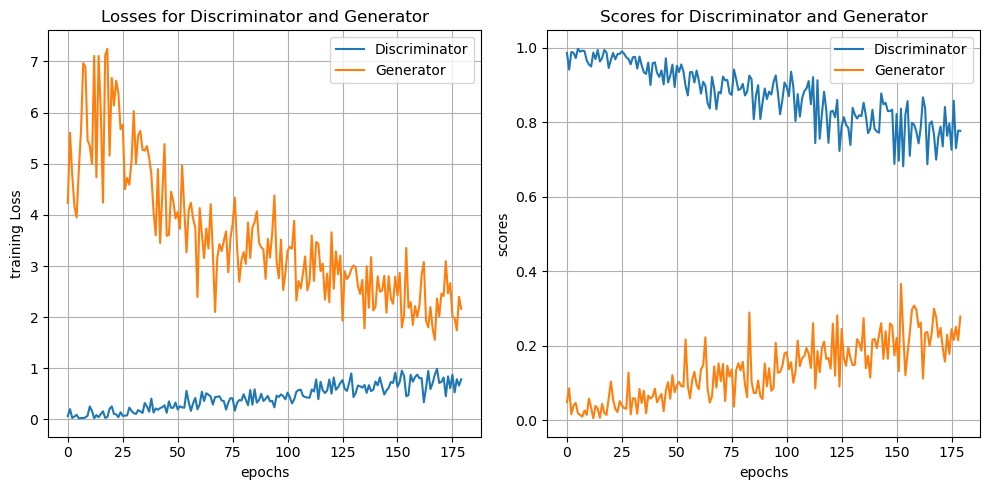

In [19]:
def plot_side_by_side(d_losses, g_losses, real_scores, fake_scores):
    
    plt.figure(figsize=(10,5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, '-')
    plt.plot(g_losses, '-')
    plt.xlabel("epochs")
    plt.ylabel("training Loss")
    plt.legend(['Discriminator', 'Generator'])
    plt.grid(True)
    plt.title("Losses for Discriminator and Generator")
    
    # Plot scores
    plt.subplot(1, 2, 2)
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')
    plt.xlabel("epochs")
    plt.ylabel("scores")
    plt.legend(['Discriminator', 'Generator'])
    plt.grid(True)
    plt.title("Scores for Discriminator and Generator")
    
    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()
    
plot_side_by_side(d_losses, g_losses, real_scores, fake_scores)

# Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.


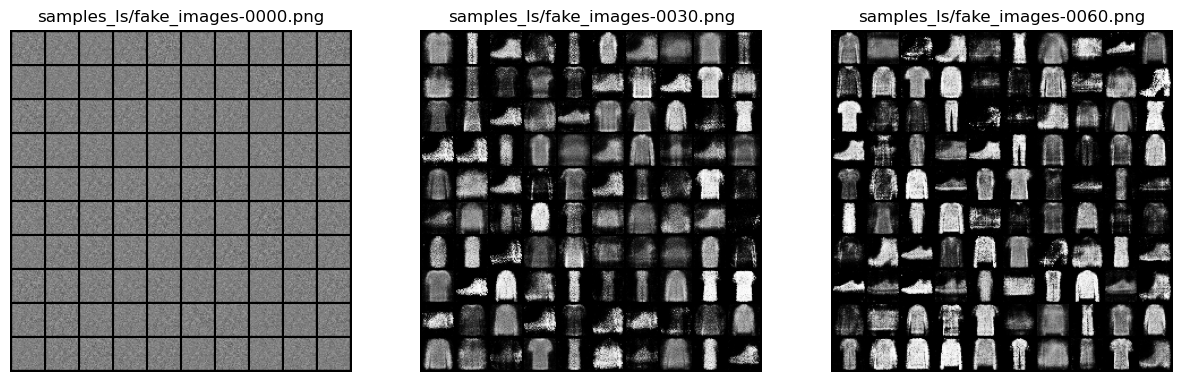

In [42]:
def select_training_samples(directory, prefix="fake_images-", suffix=".png"):
    # List all files in the directory
    files = os.listdir(directory)
    
    candidates = []
    for file in files:
        if (os.path.isfile(os.path.join(directory, file)) and
             file.startswith(prefix) and file.endswith(suffix)):
            candidates.append(file)
        
    candidates.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)))
    oldest_file = candidates[0]
    latest_file = candidates[-1]
    middle_file = candidates[len(files)//2]
    
    return list(map(lambda file: f'{sample_dir}/{file}', [oldest_file, middle_file, latest_file]))


show_images(select_training_samples(sample_dir))

# Step4. Save the model weights in the folder to be used later.


In [21]:
# Create a dictionary to store necessary information
d_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': D.state_dict(),
    'optimizer_state_dict': d_optimizer.state_dict(),
}

torch.save(d_checkpoint, f'{sample_dir}/discriminator_checkpoint.ckpt')

In [22]:
# Create a dictionary to store necessary information
g_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': G.state_dict(),
    'optimizer_state_dict': g_optimizer.state_dict(),
}

torch.save(g_checkpoint, f'{sample_dir}/generator_checkpoint.ckpt')

# Step5. Load the model using the saved weights.


In [23]:
Dl= discriminator_network()

# Load the checkpoint
d_checkpoint = torch.load(f'{sample_dir}/discriminator_checkpoint.ckpt')

# Load model weights and optimizer state
Dl.load_state_dict(d_checkpoint['model_state_dict'])
d_optimizer.load_state_dict(d_checkpoint['optimizer_state_dict'])
num_epoch = d_checkpoint['epoch']

print(f"Discriminator Model's training for {num_epoch} iternations,  state_dict:")
for param_tensor in Dl.state_dict():
    print("\t", param_tensor, "\t", Dl.state_dict()[param_tensor].size())

Discriminator Model's training for 60 iternations,  state_dict:
	 0.weight 	 torch.Size([256, 784])
	 0.bias 	 torch.Size([256])
	 2.weight 	 torch.Size([256, 256])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([1, 256])
	 4.bias 	 torch.Size([1])


In [24]:
Gl= generator_network()

# Load the checkpoint
g_checkpoint = torch.load(f'{sample_dir}/generator_checkpoint.ckpt')

# Load model weights and optimizer state
Gl.load_state_dict(g_checkpoint['model_state_dict'])
g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dict'])
num_epoch = g_checkpoint['epoch']

print(f"Generator Model's training for {num_epoch} iternations,  state_dict:")
for param_tensor in Gl.state_dict():
    print("\t", param_tensor, "\t", Gl.state_dict()[param_tensor].size())

Generator Model's training for 60 iternations,  state_dict:
	 0.weight 	 torch.Size([256, 64])
	 0.bias 	 torch.Size([256])
	 2.weight 	 torch.Size([256, 256])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([784, 256])
	 4.bias 	 torch.Size([784])


# Step 6: Re-train the GAN model to see if you can improve.


In [25]:
def discriminator_network_new():
    return nn.Sequential(
        nn.Linear(image_size, hidden_size*2),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size*2, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

In [26]:
def generator_network_new():
    return nn.Sequential(
        nn.Linear(latent_size, hidden_size*2),
        nn.ReLU(),
        nn.Linear(hidden_size*2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

	Saving  samples_new/fake_images-0000.png


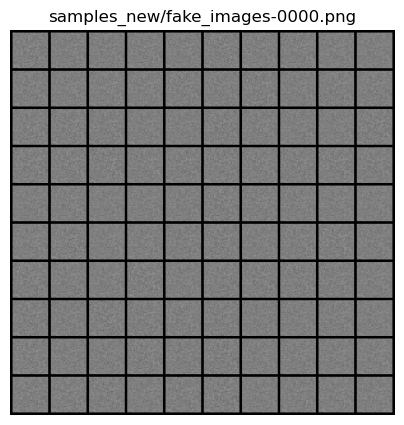

Epoch [0/60], Step [200/600], d_loss: 0.0058, g_loss: 9.6390, D(x): 1.00, D(G(z)): 0.01
Epoch [0/60], Step [400/600], d_loss: 0.2849, g_loss: 4.3043, D(x): 0.92, D(G(z)): 0.13
Epoch [0/60], Step [600/600], d_loss: 0.2955, g_loss: 4.9388, D(x): 0.96, D(G(z)): 0.20
	Saving  samples_new/fake_images-0001.png
Epoch [1/60], Step [200/600], d_loss: 0.4768, g_loss: 7.0541, D(x): 0.97, D(G(z)): 0.35
Epoch [1/60], Step [400/600], d_loss: 0.3720, g_loss: 6.0440, D(x): 0.97, D(G(z)): 0.28
Epoch [1/60], Step [600/600], d_loss: 0.4274, g_loss: 3.0023, D(x): 0.88, D(G(z)): 0.09
	Saving  samples_new/fake_images-0002.png
Epoch [2/60], Step [200/600], d_loss: 0.2312, g_loss: 6.1576, D(x): 0.95, D(G(z)): 0.14
Epoch [2/60], Step [400/600], d_loss: 0.5808, g_loss: 8.7366, D(x): 0.84, D(G(z)): 0.00
Epoch [2/60], Step [600/600], d_loss: 0.3820, g_loss: 5.0486, D(x): 0.89, D(G(z)): 0.02
	Saving  samples_new/fake_images-0003.png
Epoch [3/60], Step [200/600], d_loss: 0.3159, g_loss: 3.8508, D(x): 0.99, D(G(z)):

Epoch [27/60], Step [200/600], d_loss: 1.1232, g_loss: 1.4509, D(x): 0.66, D(G(z)): 0.41
Epoch [27/60], Step [400/600], d_loss: 0.9928, g_loss: 1.3217, D(x): 0.66, D(G(z)): 0.36
Epoch [27/60], Step [600/600], d_loss: 1.2652, g_loss: 1.2825, D(x): 0.57, D(G(z)): 0.37
	Saving  samples_new/fake_images-0028.png
Epoch [28/60], Step [200/600], d_loss: 1.0946, g_loss: 1.5694, D(x): 0.68, D(G(z)): 0.42
Epoch [28/60], Step [400/600], d_loss: 1.0957, g_loss: 1.3855, D(x): 0.59, D(G(z)): 0.32
Epoch [28/60], Step [600/600], d_loss: 1.0106, g_loss: 1.3239, D(x): 0.66, D(G(z)): 0.35
	Saving  samples_new/fake_images-0029.png
Epoch [29/60], Step [200/600], d_loss: 1.1721, g_loss: 1.2726, D(x): 0.67, D(G(z)): 0.45
Epoch [29/60], Step [400/600], d_loss: 1.1626, g_loss: 1.2142, D(x): 0.58, D(G(z)): 0.35
Epoch [29/60], Step [600/600], d_loss: 1.0092, g_loss: 1.2849, D(x): 0.66, D(G(z)): 0.37
	Saving  samples_new/fake_images-0030.png
Epoch [30/60], Step [200/600], d_loss: 1.0054, g_loss: 1.2380, D(x): 0.68

Epoch [53/60], Step [600/600], d_loss: 1.1893, g_loss: 1.1492, D(x): 0.62, D(G(z)): 0.40
	Saving  samples_new/fake_images-0054.png
Epoch [54/60], Step [200/600], d_loss: 1.1610, g_loss: 1.1590, D(x): 0.59, D(G(z)): 0.35
Epoch [54/60], Step [400/600], d_loss: 1.2629, g_loss: 1.1913, D(x): 0.59, D(G(z)): 0.44
Epoch [54/60], Step [600/600], d_loss: 1.2020, g_loss: 1.2090, D(x): 0.66, D(G(z)): 0.46
	Saving  samples_new/fake_images-0055.png
Epoch [55/60], Step [200/600], d_loss: 1.0343, g_loss: 1.1109, D(x): 0.57, D(G(z)): 0.29
Epoch [55/60], Step [400/600], d_loss: 1.1079, g_loss: 1.0405, D(x): 0.54, D(G(z)): 0.30
Epoch [55/60], Step [600/600], d_loss: 0.9602, g_loss: 1.1334, D(x): 0.66, D(G(z)): 0.36
	Saving  samples_new/fake_images-0056.png
Epoch [56/60], Step [200/600], d_loss: 1.0557, g_loss: 1.0429, D(x): 0.61, D(G(z)): 0.35
Epoch [56/60], Step [400/600], d_loss: 1.1444, g_loss: 1.2964, D(x): 0.54, D(G(z)): 0.32
Epoch [56/60], Step [600/600], d_loss: 1.0604, g_loss: 1.0112, D(x): 0.63

In [27]:
D_new = discriminator_network_new()
D_new.to(device);

G_new = generator_network_new()
G_new.to(device);


num_epochs  = 60
criterion_new   = nn.BCELoss()
d_optimizer_new = torch.optim.Adam(D_new.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer_new = torch.optim.Adam(G_new.parameters(), lr=0.0002, betas=(0.5, 0.999))

sample_dir = "samples_new"

d_losses2, g_losses2, real_scores2, fake_scores2 = train_gan(G_new, D_new, train_loader, num_epochs, 
                                                             sample_dir, batch_size, latent_size, 
                                                             criterion_new, g_optimizer_new, d_optimizer_new)


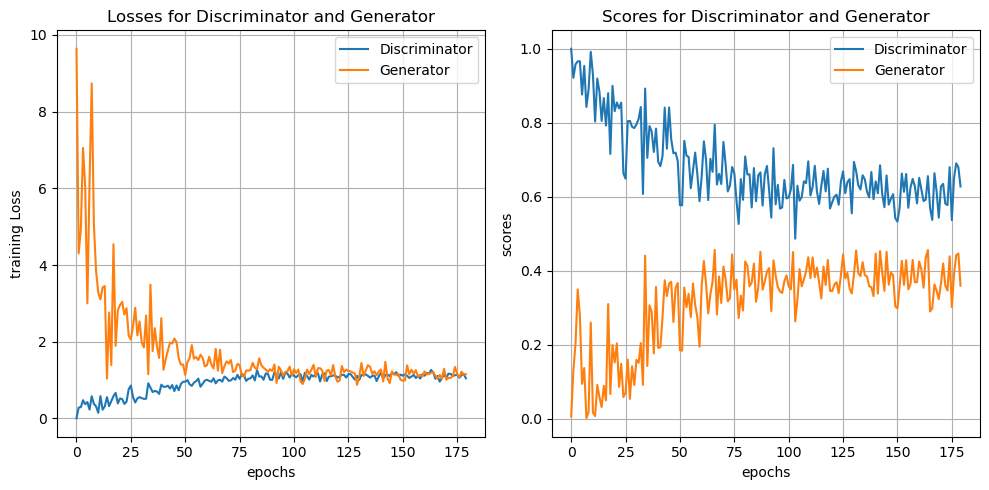

In [28]:
plot_side_by_side(d_losses2, g_losses2, real_scores2, fake_scores2)

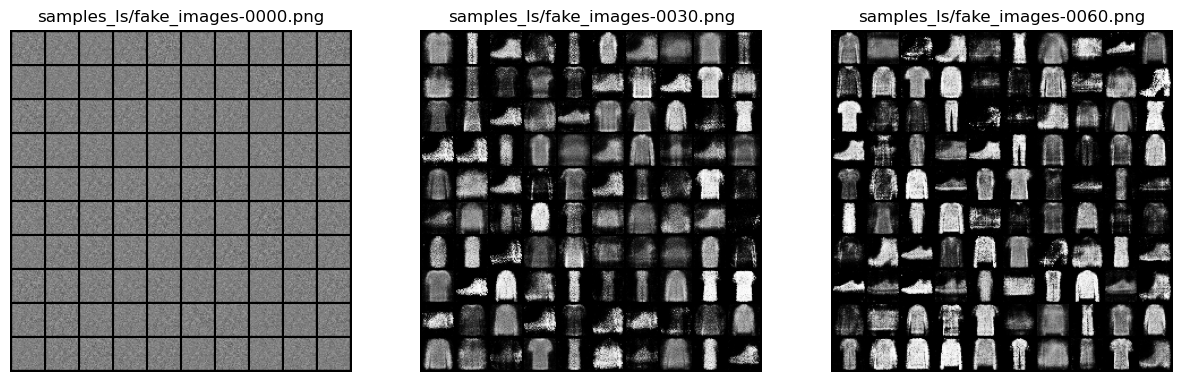

In [44]:
show_images(select_training_samples(sample_dir))

# Step 7: Save the model weights without using checkpoints.


In [30]:
torch.save(D_new.state_dict(), f'{sample_dir}/discriminator_model_weights.pth')
torch.save(G_new.state_dict(), f'{sample_dir}/generator_model_weights.pth')

# Step 8: Load the model weights without using checkpoints

In [31]:
Dnew = discriminator_network_new()
Dnew.load_state_dict(torch.load(f'{sample_dir}/discriminator_model_weights.pth'))
print("\nDiscriminator Model's state_dict:")
for param_tensor in Dnew.state_dict():
    print("\t", param_tensor, "\t", Dnew.state_dict()[param_tensor].size())



Discriminator Model's state_dict:
	 0.weight 	 torch.Size([512, 784])
	 0.bias 	 torch.Size([512])
	 2.weight 	 torch.Size([256, 512])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([256, 256])
	 4.bias 	 torch.Size([256])
	 6.weight 	 torch.Size([1, 256])
	 6.bias 	 torch.Size([1])


In [32]:
Gnew = generator_network_new()
Gnew.load_state_dict(torch.load(f'{sample_dir}/generator_model_weights.pth'))
print("\nGenerator Model's state_dict:")
for param_tensor in Gnew.state_dict():
    print("\t", param_tensor, "\t", Gnew.state_dict()[param_tensor].size())


Generator Model's state_dict:
	 0.weight 	 torch.Size([512, 64])
	 0.bias 	 torch.Size([512])
	 2.weight 	 torch.Size([256, 512])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([256, 256])
	 4.bias 	 torch.Size([256])
	 6.weight 	 torch.Size([784, 256])
	 6.bias 	 torch.Size([784])



# Part-2 LSGAN

Formula for the Loss funcion in LSGAN, as it uses the Mean Square Error

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*IAr9NKm1nrVQLVgOdD5J4g.png" width="620" >


# Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

In [33]:
# def train_discriminator2(G, D, real_images, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
#     # Create the labels which are later used as input for the BCE loss
#     d_optimizer.zero_grad()
#     real_labels = torch.ones(batch_size, 1).to(device)
#     fake_labels = torch.zeros(batch_size, 1).to(device)
#     z = torch.randn(batch_size, latent_size).to(device)
    
#     # Loss for real images
#     real_score = D(real_images)
#     d_loss_real = criterion(real_score, real_labels)

#     # Loss for fake images
#     fake_images = G(z)
#     fake_score = D(fake_images)
#     d_loss_fake = criterion(fake_score, fake_labels)

#     d_loss = d_loss_real + d_loss_fake  # Combine losses
#     d_loss.backward()  # Compute gradients
#     d_optimizer.step() # Adjust the parameters using backprop
    
#     return d_loss, real_score, fake_score

# def train_generator2(G, D, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
#     g_optimizer.zero_grad()
    
#     # Generate fake images and calculate loss
#     z = torch.randn(batch_size, latent_size).to(device)
#     fake_images = G(z)
#     real_labels = torch.ones(batch_size, 1).to(device)
#     fake_output = D(fake_images)
#     g_loss = criterion(fake_output, real_labels)
#     g_loss.backward()
#     g_optimizer.step()
#     return g_loss, fake_images


# def train_gan2(G, D, data_loader, num_epochs, sample_dir, 
#               batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    
#     if not os.path.exists(sample_dir):
#         os.makedirs(sample_dir)

#     save_fake_images(G, 0, sample_dir=sample_dir)
#     show_images([os.path.join(sample_dir, 'fake_images-0000.png')])
    
#     total_step = len(data_loader)
#     d_losses, g_losses, real_scores, fake_scores = [], [], [], []
    
    
#     # Training loop
#     for epoch in range(num_epochs):
#         for i, (real_images, _) in enumerate(data_loader):
#             batch_size = real_images.size(0)
#             real_images = real_images.view(batch_size, -1).to(device)
            
# #             # Train Discriminator
# #             d_optimizer.zero_grad()
# #             real_labels = torch.ones(batch_size, 1).to(device)
# #             fake_labels = torch.zeros(batch_size, 1).to(device)
# #             z = torch.randn(batch_size, latent_size).to(device)
# #             fake_images = G(z)
# #             real_score = D(real_images)
# #             fake_score = D(fake_images.detach())  # detach to avoid generator gradients here
# #             d_loss = 0.5 * (criterion(real_score, real_labels) + criterion(fake_score, fake_labels))
# #             d_loss.backward()
# #             d_optimizer.step()
#             d_loss, real_score, fake_score = train_discriminator2(G, D, real_images, batch_size, latent_size, 
#                                                                  criterion, g_optimizer, d_optimizer)
# #             g_loss, fake_images = train_generator2(G, D, batch_size, latent_size, 
# #                                                   criterion, g_optimizer, d_optimizer)
#             # Train Generator
#             g_optimizer.zero_grad()
#             real_labels = torch.ones(batch_size, 1).to(device)
#             z = torch.randn(batch_size, latent_size).to(device)
#             fake_images = G(z)
#             fake_output = D(fake_images)
#             g_loss = 0.5 * criterion(fake_output, real_labels)
#             g_loss.backward()
#             g_optimizer.step()

#             # Inspect the losses
#             if (i+1) % (total_step//3) == 0:
#                 d_losses.append(d_loss.item())
#                 g_losses.append(g_loss.item())
#                 real_scores.append(real_score.mean().item())
#                 fake_scores.append(fake_score.mean().item())
#                 print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], ' +
#                   f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, ' + 
#                   f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')


#         save_fake_images(G, epoch+1, sample_dir)

#     return d_losses, g_losses, real_scores, fake_scores
        

# def discriminator_network_ls():
#     return nn.Sequential(
#         nn.Linear(image_size, hidden_size),
#         nn.LeakyReLU(0.2),
#         nn.Linear(hidden_size, hidden_size),
#         nn.LeakyReLU(0.2),
#         nn.Linear(hidden_size, 1))

# D_ls = discriminator_network_ls()
# D_ls.to(device);

# G_ls = generator_network()
# G_ls.to(device);


# sample_dir = "samples_ls"

# num_epochs  = 10
# criterion_ls   = nn.MSELoss()
# d_optimizer_ls = torch.optim.Adam(D_ls.parameters(), lr=0.0002, betas=(0.5, 0.999))
# g_optimizer_ls = torch.optim.Adam(G_ls.parameters(), lr=0.0002, betas=(0.5, 0.999))

# d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls = train_gan2(G_ls, D_ls, train_loader, 
#                                                                      num_epochs, sample_dir, 
#                                                                      batch_size, latent_size, criterion_ls, 
#                                                                      g_optimizer_ls, d_optimizer_ls)
# plot_side_by_side(d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls)

In [45]:
def train_lsgan_discriminator(G, D, real_images, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    # Create the labels which are later used as input for the BCE loss
    d_optimizer.zero_grad()
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    z = torch.randn(batch_size, latent_size).to(device)
    
    # Loss for real images
    real_score = D(real_images)
    d_loss_real = criterion(real_score, real_labels)

    # Loss for fake images
    fake_images = G(z)
    fake_score = D(fake_images)
    d_loss_fake = criterion(fake_score, fake_labels)

    d_loss = 1/2 * (d_loss_real + d_loss_fake)  # Combine losses
    d_loss.backward()  # Compute gradients
    d_optimizer.step() # Adjust the parameters using backprop
    
    return d_loss, real_score, fake_score


def train_lsgan_generator2(G, D, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    g_optimizer.zero_grad()
    
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_output = D(fake_images)
    g_loss = 1/2 * criterion(fake_output, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images



def train_lsgan_gan(G, D, data_loader, num_epochs, sample_dir, 
              batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    save_fake_images(G, 0, sample_dir=sample_dir)
#     show_images([os.path.join(sample_dir, 'fake_images-0000.png')])
    
    total_step = len(data_loader)
    d_losses, g_losses, real_scores, fake_scores = [], [], [], []

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            
            # Load a batch & transform to vectors
            images = images.reshape(batch_size, -1).to(device)

            # Train the discriminator and generator
            d_loss, real_score, fake_score = train_lsgan_discriminator(G, D, images, batch_size, latent_size, 
                                                                       criterion, g_optimizer, d_optimizer)
            g_loss, fake_images = train_lsgan_generator2(G, D, batch_size, latent_size, 
                                                         criterion, g_optimizer, d_optimizer)

            # Inspect the losses
            if (i+1) % (total_step//3) == 0:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], ' +
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, ' + 
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

                
        # Sample and save images
        save_fake_images(G, epoch+1, sample_dir)

    return d_losses, g_losses, real_scores, fake_scores
        
        

	Saving  samples_ls/fake_images-0000.png


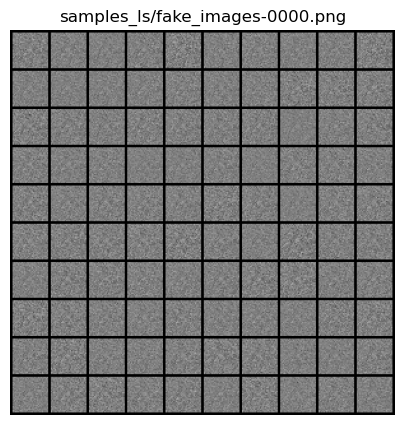

Epoch [0/60], Step [200/600], d_loss: 0.0055, g_loss: 1.1715, D(x): 0.99, D(G(z)): 0.00
Epoch [0/60], Step [400/600], d_loss: 0.0161, g_loss: 1.2960, D(x): 0.97, D(G(z)): 0.03
Epoch [0/60], Step [600/600], d_loss: 0.0102, g_loss: 1.1489, D(x): 0.98, D(G(z)): 0.00
	Saving  samples_ls/fake_images-0001.png
Epoch [1/60], Step [200/600], d_loss: 0.0174, g_loss: 1.1005, D(x): 0.98, D(G(z)): 0.07
Epoch [1/60], Step [400/600], d_loss: 0.0152, g_loss: 1.1242, D(x): 0.98, D(G(z)): 0.04
Epoch [1/60], Step [600/600], d_loss: 0.0134, g_loss: 1.2418, D(x): 1.00, D(G(z)): 0.02
	Saving  samples_ls/fake_images-0002.png
Epoch [2/60], Step [200/600], d_loss: 0.0129, g_loss: 1.0271, D(x): 0.95, D(G(z)): -0.02
Epoch [2/60], Step [400/600], d_loss: 0.0267, g_loss: 1.0133, D(x): 0.93, D(G(z)): -0.05
Epoch [2/60], Step [600/600], d_loss: 0.0322, g_loss: 0.9090, D(x): 1.00, D(G(z)): 0.11
	Saving  samples_ls/fake_images-0003.png
Epoch [3/60], Step [200/600], d_loss: 0.0145, g_loss: 1.0757, D(x): 1.00, D(G(z)): 

Epoch [27/60], Step [200/600], d_loss: 0.0902, g_loss: 0.8268, D(x): 0.93, D(G(z)): 0.11
Epoch [27/60], Step [400/600], d_loss: 0.1319, g_loss: 0.9017, D(x): 0.85, D(G(z)): 0.11
Epoch [27/60], Step [600/600], d_loss: 0.1552, g_loss: 0.6872, D(x): 0.84, D(G(z)): 0.19
	Saving  samples_ls/fake_images-0028.png
Epoch [28/60], Step [200/600], d_loss: 0.1435, g_loss: 0.8894, D(x): 0.88, D(G(z)): 0.13
Epoch [28/60], Step [400/600], d_loss: 0.1098, g_loss: 0.9116, D(x): 0.83, D(G(z)): 0.08
Epoch [28/60], Step [600/600], d_loss: 0.1222, g_loss: 0.8101, D(x): 0.91, D(G(z)): 0.17
	Saving  samples_ls/fake_images-0029.png
Epoch [29/60], Step [200/600], d_loss: 0.1173, g_loss: 0.9687, D(x): 0.84, D(G(z)): 0.07
Epoch [29/60], Step [400/600], d_loss: 0.1456, g_loss: 0.8798, D(x): 0.85, D(G(z)): 0.13
Epoch [29/60], Step [600/600], d_loss: 0.1861, g_loss: 0.7506, D(x): 0.77, D(G(z)): 0.19
	Saving  samples_ls/fake_images-0030.png
Epoch [30/60], Step [200/600], d_loss: 0.1727, g_loss: 0.8354, D(x): 0.89, D

Epoch [54/60], Step [200/600], d_loss: 0.2856, g_loss: 0.5810, D(x): 0.68, D(G(z)): 0.24
Epoch [54/60], Step [400/600], d_loss: 0.2400, g_loss: 0.6547, D(x): 0.74, D(G(z)): 0.26
Epoch [54/60], Step [600/600], d_loss: 0.2823, g_loss: 0.6440, D(x): 0.71, D(G(z)): 0.27
	Saving  samples_ls/fake_images-0055.png
Epoch [55/60], Step [200/600], d_loss: 0.3951, g_loss: 0.5025, D(x): 0.63, D(G(z)): 0.30
Epoch [55/60], Step [400/600], d_loss: 0.1715, g_loss: 0.7432, D(x): 0.82, D(G(z)): 0.24
Epoch [55/60], Step [600/600], d_loss: 0.2031, g_loss: 0.7347, D(x): 0.80, D(G(z)): 0.21
	Saving  samples_ls/fake_images-0056.png
Epoch [56/60], Step [200/600], d_loss: 0.2247, g_loss: 0.6829, D(x): 0.73, D(G(z)): 0.18
Epoch [56/60], Step [400/600], d_loss: 0.2693, g_loss: 0.5957, D(x): 0.69, D(G(z)): 0.24
Epoch [56/60], Step [600/600], d_loss: 0.3126, g_loss: 0.5219, D(x): 0.76, D(G(z)): 0.35
	Saving  samples_ls/fake_images-0057.png
Epoch [57/60], Step [200/600], d_loss: 0.3175, g_loss: 0.5331, D(x): 0.77, D

In [35]:
def discriminator_network_ls():
    return nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
    )

D_ls = discriminator_network_ls()
D_ls.to(device);

G_ls = generator_network()
G_ls.to(device);


sample_dir = "samples_ls"

num_epochs  = 60
criterion_ls   = nn.MSELoss()
d_optimizer_ls = torch.optim.Adam(D_ls.parameters(), lr=0.0002)
g_optimizer_ls = torch.optim.Adam(G_ls.parameters(), lr=0.0002)

d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls = train_gan(G_ls, D_ls, train_loader, 
                                                                     num_epochs, sample_dir, 
                                                                     batch_size, latent_size, criterion_ls, 
                                                                     g_optimizer_ls, d_optimizer_ls)


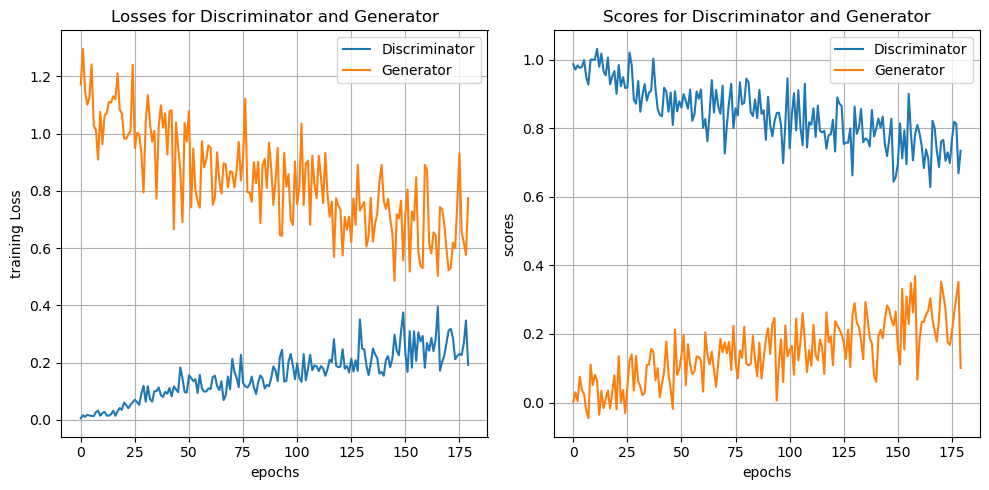

In [47]:
plot_side_by_side(d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls)

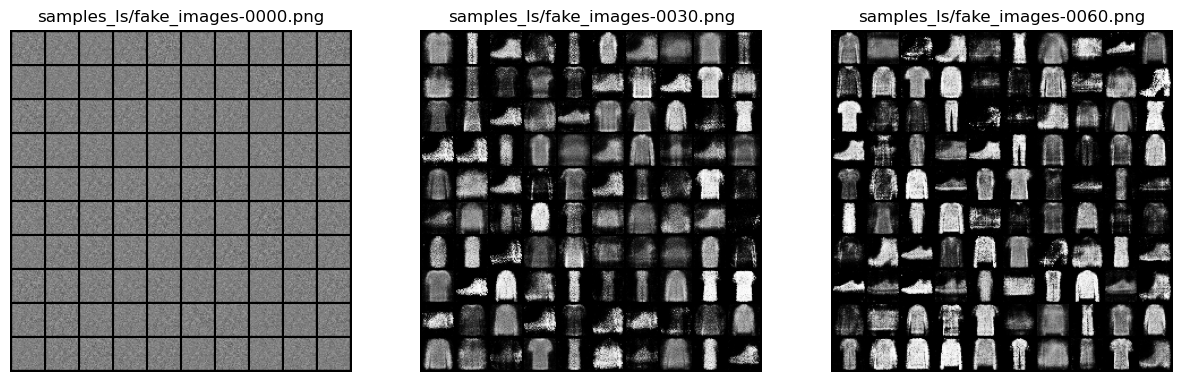

In [48]:
show_images(select_training_samples(sample_dir))

	Saving  sample_ls_new/fake_images-0000.png


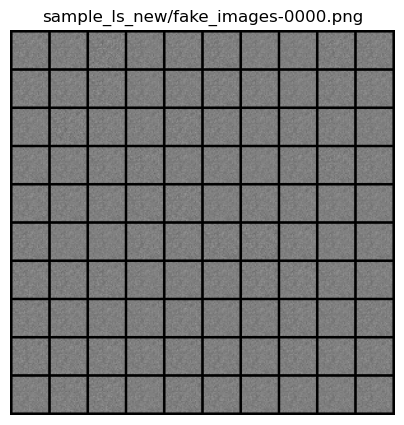

Epoch [0/60], Step [200/600], d_loss: 0.0038, g_loss: 1.1364, D(x): 1.00, D(G(z)): -0.01
Epoch [0/60], Step [400/600], d_loss: 0.0086, g_loss: 1.2425, D(x): 0.98, D(G(z)): 0.05
Epoch [0/60], Step [600/600], d_loss: 0.0458, g_loss: 1.2438, D(x): 0.96, D(G(z)): -0.05
	Saving  sample_ls_new/fake_images-0001.png
Epoch [1/60], Step [200/600], d_loss: 0.0075, g_loss: 1.2203, D(x): 0.99, D(G(z)): 0.01
Epoch [1/60], Step [400/600], d_loss: 0.0078, g_loss: 1.2097, D(x): 0.99, D(G(z)): 0.04
Epoch [1/60], Step [600/600], d_loss: 0.0130, g_loss: 1.2027, D(x): 0.98, D(G(z)): 0.00
	Saving  sample_ls_new/fake_images-0002.png
Epoch [2/60], Step [200/600], d_loss: 0.0073, g_loss: 1.2040, D(x): 1.00, D(G(z)): 0.03
Epoch [2/60], Step [400/600], d_loss: 0.0105, g_loss: 1.1335, D(x): 1.00, D(G(z)): -0.02
Epoch [2/60], Step [600/600], d_loss: 0.0102, g_loss: 1.3326, D(x): 0.99, D(G(z)): 0.01
	Saving  sample_ls_new/fake_images-0003.png
Epoch [3/60], Step [200/600], d_loss: 0.0043, g_loss: 1.1617, D(x): 1.00,

Epoch [26/60], Step [600/600], d_loss: 0.1459, g_loss: 0.9327, D(x): 0.88, D(G(z)): 0.15
	Saving  sample_ls_new/fake_images-0027.png
Epoch [27/60], Step [200/600], d_loss: 0.1569, g_loss: 1.0052, D(x): 0.83, D(G(z)): 0.13
Epoch [27/60], Step [400/600], d_loss: 0.1678, g_loss: 0.9588, D(x): 0.82, D(G(z)): 0.03
Epoch [27/60], Step [600/600], d_loss: 0.1599, g_loss: 0.7645, D(x): 0.85, D(G(z)): 0.20
	Saving  sample_ls_new/fake_images-0028.png
Epoch [28/60], Step [200/600], d_loss: 0.1896, g_loss: 0.6701, D(x): 0.74, D(G(z)): 0.12
Epoch [28/60], Step [400/600], d_loss: 0.2081, g_loss: 0.6788, D(x): 0.81, D(G(z)): 0.15
Epoch [28/60], Step [600/600], d_loss: 0.1768, g_loss: 0.8204, D(x): 0.80, D(G(z)): 0.16
	Saving  sample_ls_new/fake_images-0029.png
Epoch [29/60], Step [200/600], d_loss: 0.1643, g_loss: 1.0773, D(x): 0.90, D(G(z)): 0.17
Epoch [29/60], Step [400/600], d_loss: 0.1625, g_loss: 0.8264, D(x): 0.80, D(G(z)): 0.11
Epoch [29/60], Step [600/600], d_loss: 0.1755, g_loss: 0.8879, D(x)

Epoch [53/60], Step [200/600], d_loss: 0.2693, g_loss: 0.6169, D(x): 0.72, D(G(z)): 0.27
Epoch [53/60], Step [400/600], d_loss: 0.2561, g_loss: 0.7817, D(x): 0.71, D(G(z)): 0.18
Epoch [53/60], Step [600/600], d_loss: 0.2059, g_loss: 0.7431, D(x): 0.78, D(G(z)): 0.20
	Saving  sample_ls_new/fake_images-0054.png
Epoch [54/60], Step [200/600], d_loss: 0.3653, g_loss: 0.4978, D(x): 0.75, D(G(z)): 0.43
Epoch [54/60], Step [400/600], d_loss: 0.2449, g_loss: 0.7385, D(x): 0.74, D(G(z)): 0.28
Epoch [54/60], Step [600/600], d_loss: 0.2307, g_loss: 0.5706, D(x): 0.77, D(G(z)): 0.25
	Saving  sample_ls_new/fake_images-0055.png
Epoch [55/60], Step [200/600], d_loss: 0.2476, g_loss: 0.6232, D(x): 0.70, D(G(z)): 0.24
Epoch [55/60], Step [400/600], d_loss: 0.2713, g_loss: 0.6179, D(x): 0.68, D(G(z)): 0.26
Epoch [55/60], Step [600/600], d_loss: 0.1432, g_loss: 0.7351, D(x): 0.82, D(G(z)): 0.12
	Saving  sample_ls_new/fake_images-0056.png
Epoch [56/60], Step [200/600], d_loss: 0.2384, g_loss: 0.6590, D(x)

In [51]:
def discriminator_network_new_ls():
    return nn.Sequential(
        nn.Linear(image_size, hidden_size*2),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size*2, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        )

D_ls_new = discriminator_network_new_ls()
D_ls_new.to(device);

G_ls_new = generator_network_new()
G_ls_new.to(device);


sample_dir = "sample_ls_new"

num_epochs  = 60
criterion_new   = nn.MSELoss()
d_optimizer_new = torch.optim.Adam(D_ls_new.parameters(), lr=0.0002)
g_optimizer_new = torch.optim.Adam(G_ls_new.parameters(), lr=0.0002)

d_losses_ls_new, g_losses_ls_new, real_scores_ls_new, fake_scores_ls_new = train_gan(G_ls_new, 
                                                                                     D_ls_new, 
                                                                                     train_loader, 
                                                                                     num_epochs, 
                                                                                     sample_dir, 
                                                                                     batch_size, latent_size, 
                                                                                     criterion_new, 
                                                                                     g_optimizer_new, 
                                                                                     d_optimizer_new)

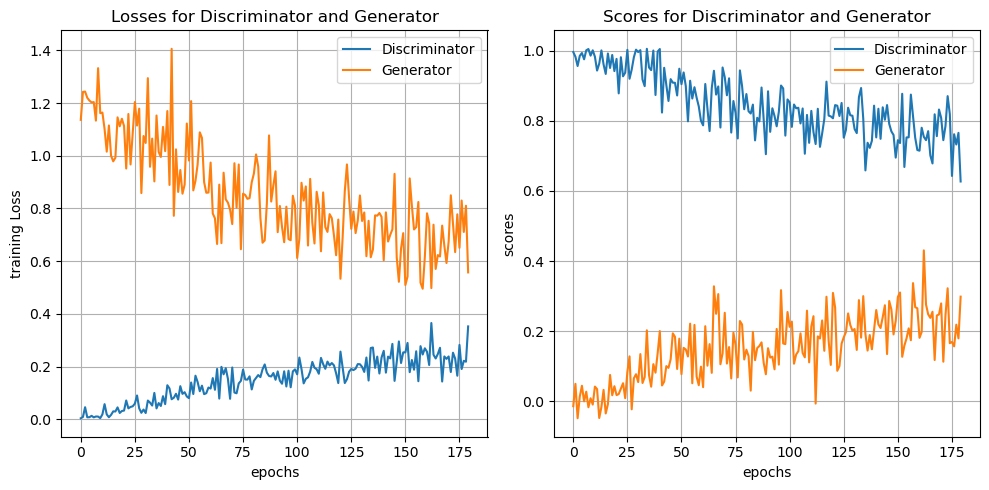

In [52]:
plot_side_by_side(d_losses_ls_new, g_losses_ls_new, real_scores_ls_new, fake_scores_ls_new)


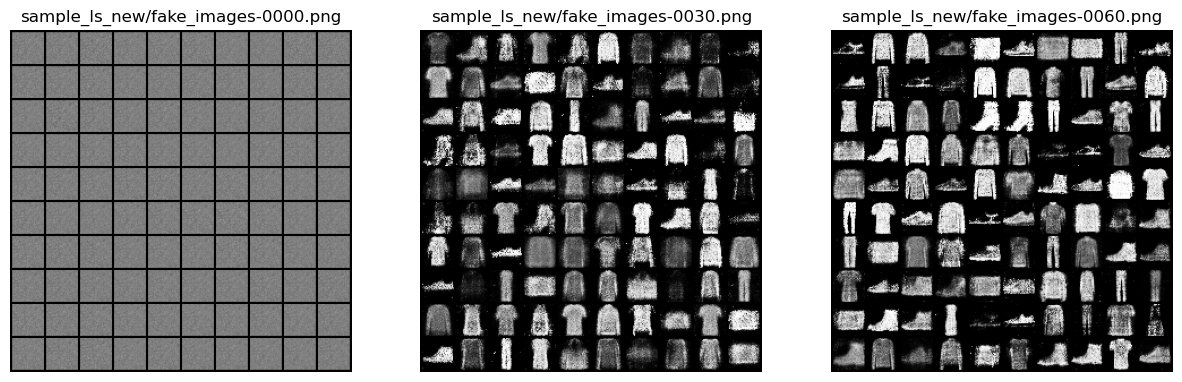

In [53]:
show_images(select_training_samples(sample_dir))

## Comparision

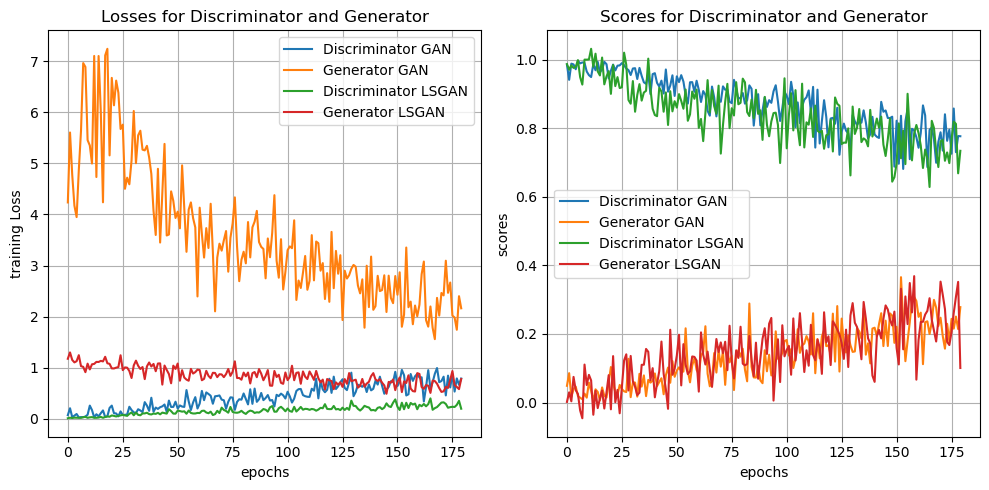

In [54]:
def plot_comparision(d_losses, g_losses, real_scores, fake_scores, marker,
                      d_losses2, g_losses2, real_scores2, fake_scores2, marker2):
    
    plt.figure(figsize=(10,5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, '-')
    plt.plot(g_losses, '-')

    plt.plot(d_losses2, '-')
    plt.plot(g_losses2, '-')
    
    plt.xlabel("epochs")
    plt.ylabel("training Loss")
    plt.legend([f'Discriminator {marker}', f'Generator {marker}',
               f'Discriminator {marker2}', f'Generator {marker2}'])
    plt.grid(True)
    plt.title("Losses for Discriminator and Generator")
    
    # Plot scores
    plt.subplot(1, 2, 2)
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')

    plt.plot(real_scores2, '-')
    plt.plot(fake_scores2, '-')
    plt.xlabel("epochs")
    plt.ylabel("scores")
    plt.legend([f'Discriminator {marker}', f'Generator {marker}',
               f'Discriminator {marker2}', f'Generator {marker2}'])
    plt.grid(True)
    plt.title("Scores for Discriminator and Generator")
    
    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()
    
plot_comparision(d_losses, g_losses, real_scores, fake_scores, "GAN", 
                d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls, "LSGAN")